# Image Quilting for Texture Synthesis and Transfer

This notebook contains all of our implemented code and example usage.

Database:

"https://raw.githubusercontent.com/axu2/image-quilting/master/"

"https://people.eecs.berkeley.edu/~efros/research/quilting/figs/transfer/"


# Image Quilting

In [0]:
import numpy as np
import math
from skimage import io, util
import heapq


def randomPatch(texture, patchLength):
    h, w, _ = texture.shape
    i = np.random.randint(h - patchLength)
    j = np.random.randint(w - patchLength)

    return texture[i:i+patchLength, j:j+patchLength]


def L2OverlapDiff(patch, patchLength, overlap, res, y, x):
    error = 0

    if x > 0:
        left = patch[:, :overlap] - res[y:y+patchLength, x:x+overlap]
        error += np.sum(left**2)

    if y > 0:
        up   = patch[:overlap, :] - res[y:y+overlap, x:x+patchLength]
        error += np.sum(up**2)

    if x > 0 and y > 0:
        corner = patch[:overlap, :overlap] - res[y:y+overlap, x:x+overlap]
        error -= np.sum(corner**2)

    return error
 

def randomBestPatch(texture, patchLength, overlap, res, y, x):
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = texture[i:i+patchLength, j:j+patchLength]
            e = L2OverlapDiff(patch, patchLength, overlap, res, y, x)
            errors[i, j] = e

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+patchLength, j:j+patchLength]



def minCutPath(errors):
    # dijkstra's algorithm vertical
    pq = [(error, [i]) for i, error in enumerate(errors[0])]
    heapq.heapify(pq)

    h, w = errors.shape
    seen = set()

    while pq:
        error, path = heapq.heappop(pq)
        curDepth = len(path)
        curIndex = path[-1]

        if curDepth == h:
            return path

        for delta in -1, 0, 1:
            nextIndex = curIndex + delta

            if 0 <= nextIndex < w:
                if (curDepth, nextIndex) not in seen:
                    cumError = error + errors[curDepth, nextIndex]
                    heapq.heappush(pq, (cumError, path + [nextIndex]))
                    seen.add((curDepth, nextIndex))


def minCutPath2(errors):
    # dynamic programming, unused
    errors = np.pad(errors, [(0, 0), (1, 1)], 
                    mode='constant', 
                    constant_values=np.inf)

    cumError = errors[0].copy()
    paths = np.zeros_like(errors, dtype=int)    

    for i in range(1, len(errors)):
        M = cumError
        L = np.roll(M, 1)
        R = np.roll(M, -1)

        # optimize with np.choose?
        cumError = np.min((L, M, R), axis=0) + errors[i]
        paths[i] = np.argmin((L, M, R), axis=0)
    
    paths -= 1
    
    minCutPath = [np.argmin(cumError)]
    for i in reversed(range(1, len(errors))):
        minCutPath.append(minCutPath[-1] + paths[i][minCutPath[-1]])
    
    return map(lambda x: x - 1, reversed(minCutPath))


def minCutPatch(patch, patchLength, overlap, res, y, x):
    patch = patch.copy()
    dy, dx, _ = patch.shape
    minCut = np.zeros_like(patch, dtype=bool)

    if x > 0:
        left = patch[:, :overlap] - res[y:y+dy, x:x+overlap]
        leftL2 = np.sum(left**2, axis=2)
        for i, j in enumerate(minCutPath(leftL2)):
            minCut[i, :j] = True

    if y > 0:
        up = patch[:overlap, :] - res[y:y+overlap, x:x+dx]
        upL2 = np.sum(up**2, axis=2)
        for j, i in enumerate(minCutPath(upL2.T)):
            minCut[:i, j] = True

    np.copyto(patch, res[y:y+dy, x:x+dx], where=minCut)

    return patch


def quilt(texture, patchLength, numPatches, mode="cut", sequence=False):
    texture = util.img_as_float(texture)

    overlap = patchLength // 6
    numPatchesHigh, numPatchesWide = numPatches

    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap

    res = np.zeros((h, w, texture.shape[2]))

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)

            if i == 0 and j == 0 or mode == "random":
                patch = randomPatch(texture, patchLength)
            elif mode == "best":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
            elif mode == "cut":
                patch = randomBestPatch(texture, patchLength, overlap, res, y, x)
                patch = minCutPatch(patch, patchLength, overlap, res, y, x)
            
            res[y:y+patchLength, x:x+patchLength] = patch

            if sequence:
                io.imshow(res)
                io.show()
      
    return res


def quiltSize(texture, patchLength, shape, mode="cut"):
    overlap = patchLength // 6
    h, w = shape

    numPatchesHigh = math.ceil((h - patchLength) / (patchLength - overlap)) + 1 or 1
    numPatchesWide = math.ceil((w - patchLength) / (patchLength - overlap)) + 1 or 1
    res = quilt(texture, patchLength, (numPatchesHigh, numPatchesWide), mode)

    return res[:h, :w]

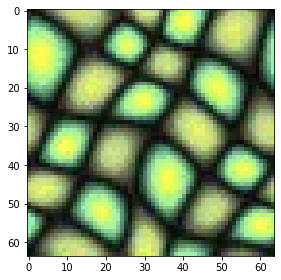

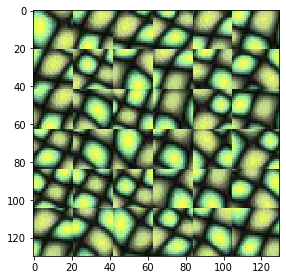

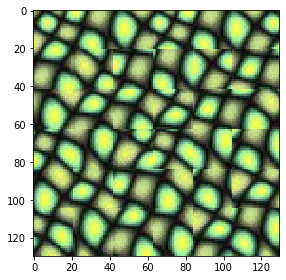

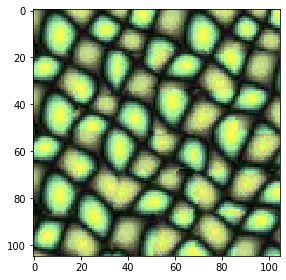

In [0]:
s = "https://raw.githubusercontent.com/axu2/image-quilting/master/"

texture = io.imread(s + "test.png")
io.imshow(texture)
io.show()

io.imshow(quilt(texture, 25, (6, 6), "random"))
io.show()

io.imshow(quilt(texture, 25, (6, 6), "best"))
io.show()

io.imshow(quilt(texture, 20, (6, 6), "cut"))
io.show()

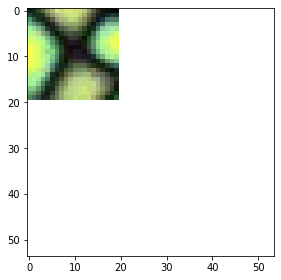

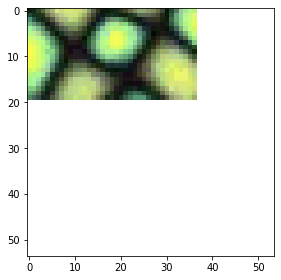

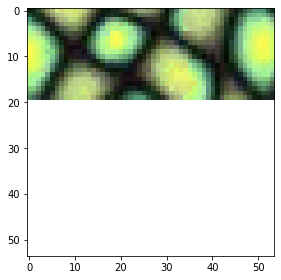

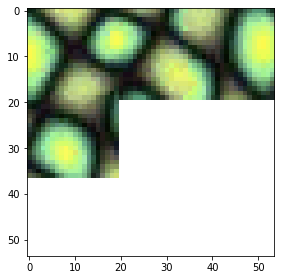

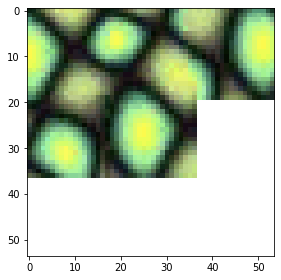

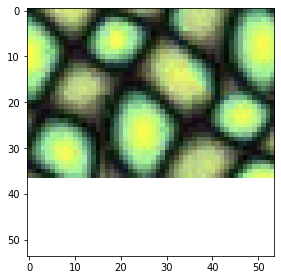

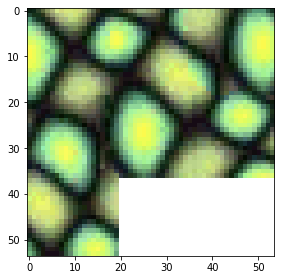

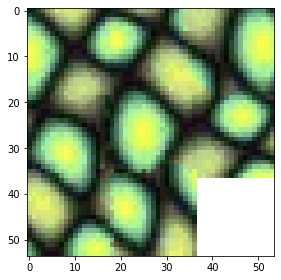

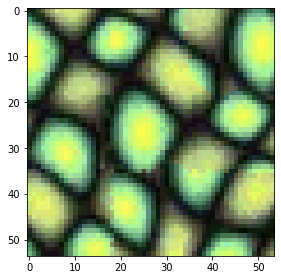

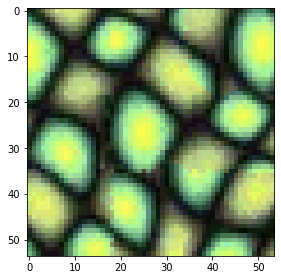

In [0]:
io.imshow(quilt(texture, 20, (3, 3), "cut", True))
io.show()

# Texture Transfer

(281, 231, 3)


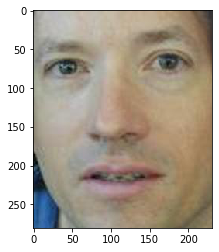

(133, 197, 4)


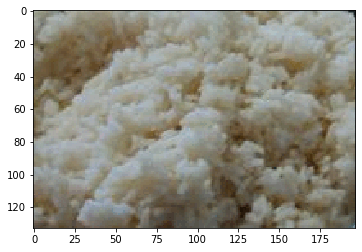

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import math
from skimage.color import rgb2gray
from skimage.filters import gaussian
import heapq

def bestCorrPatch(texture, corrTexture, patchLength, corrTarget, y, x):
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    corrTargetPatch = corrTarget[y:y+patchLength, x:x+patchLength]
    curPatchHeight, curPatchWidth = corrTargetPatch.shape

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            corrTexturePatch = corrTexture[i:i+curPatchHeight, j:j+curPatchWidth]
            e = corrTexturePatch - corrTargetPatch
            errors[i, j] = np.sum(e**2)

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+curPatchHeight, j:j+curPatchWidth]

def bestCorrOverlapPatch(texture, corrTexture, patchLength, overlap, 
                         corrTarget, res, y, x, alpha=0.1, level=0):
    h, w, _ = texture.shape
    errors = np.zeros((h - patchLength, w - patchLength))

    corrTargetPatch = corrTarget[y:y+patchLength, x:x+patchLength]
    di, dj = corrTargetPatch.shape

    for i in range(h - patchLength):
        for j in range(w - patchLength):
            patch = texture[i:i+di, j:j+dj]
            l2error = L2OverlapDiff(patch, patchLength, overlap, res, y, x)
            overlapError = np.sum(l2error)

            corrTexturePatch = corrTexture[i:i+di, j:j+dj]
            corrError = np.sum((corrTexturePatch - corrTargetPatch)**2)

            prevError = 0
            if level > 0:
                prevError = patch[overlap:, overlap:] - res[y+overlap:y+patchLength, x+overlap:x+patchLength]
                prevError = np.sum(prevError**2)
            
            errors[i, j] = alpha * (overlapError + prevError) + (1 - alpha) * corrError

    i, j = np.unravel_index(np.argmin(errors), errors.shape)
    return texture[i:i+di, j:j+dj]



def transfer(texture, target, patchLength, mode="cut", 
             alpha=0.1, level=0, prior=None, blur=False):
    corrTexture = rgb2gray(texture)
    corrTarget  = rgb2gray(target)

    if blur:
        corrTexture = gaussian(corrTexture, sigma=3)
        corrTarget  = gaussian(corrTarget,  sigma=3)

    io.imshow(corrTexture)
    io.show()
    io.imshow(corrTarget)
    io.show()

    # remove alpha channel
    texture = util.img_as_float(texture)[:,:,:3]
    target = util.img_as_float(target)[:,:,:3]

    h, w, _ = target.shape
    overlap = patchLength // 6

    numPatchesHigh = math.ceil((h - patchLength) / (patchLength - overlap)) + 1 or 1
    numPatchesWide = math.ceil((w - patchLength) / (patchLength - overlap)) + 1 or 1
    
    if level == 0:
        res = np.zeros_like(target)
    else:
        res = prior

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)

            if i == 0 and j == 0 or mode == "best":
                patch = bestCorrPatch(texture, corrTexture, patchLength, corrTarget, y, x)
            elif mode == "overlap":
                patch = bestCorrOverlapPatch(texture, corrTexture, patchLength, 
                                             overlap, corrTarget, res, y, x)
            elif mode == "cut":
                patch = bestCorrOverlapPatch(texture, corrTexture, patchLength, 
                                             overlap, corrTarget, res, y, x, 
                                             alpha, level)
                patch = minCutPatch(patch, patchLength, overlap, res, y, x)
            
            res[y:y+patchLength, x:x+patchLength] = patch
      
    return res

def transferIter(texture, target, patchLength, n):
    res = transfer(texture, target, patchLength)
    for i in range(1, n):
        alpha = 0.1 + 0.8 * i / (n - 1)
        patchLength = patchLength * 2**i // 3**i
        print((alpha, patchLength))
        res = transfer(texture, target, patchLength, 
                       alpha=alpha, level=i, prior=res)
    
    return res


s = "https://people.eecs.berkeley.edu/~efros/research/quilting/figs/transfer/"

bill = io.imread(s + "bill-big.jpg")
rice = io.imread(s + "rice.gif")

print(bill.shape)
plt.imshow(bill)
plt.show()

print(rice.shape)
plt.imshow(rice)
plt.show()

In [0]:
## Loss function

def Loss_function(original, syn):
  height, width, depth = original.shape
  for i in range(height):
      loss3 += np.sqrt(np.sum(np.square(original[i][:,0:3]/np.max(original) - syn[i]/np.max(syn))))


(0.9, 13)
CPU times: user 15min 32s, sys: 84.9 ms, total: 15min 32s
Wall time: 15min 33s


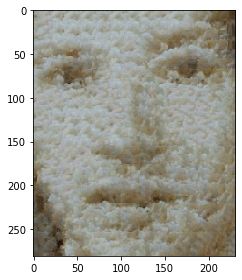

In [0]:
%time res2 = transferIter(rice, bill, 20, 2)
io.imshow(res2)
io.show()

In [0]:
io.imsave("ricebill2.png", res2)

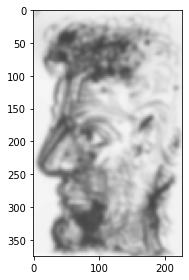

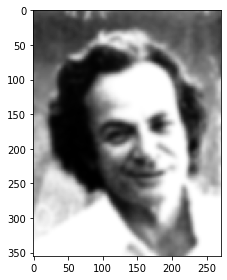

CPU times: user 18min 30s, sys: 335 ms, total: 18min 30s
Wall time: 18min 31s


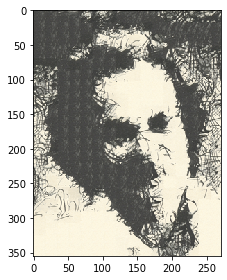

In [0]:
%time res3 = transfer(drawing, man, 20, blur=True)
io.imshow(res3)
io.show()
io.imsave("drawingman.png", res3)